Esta notebook es para ir a airbnb a chekear los precios de los alquileres, porque algunos no eran correctos.

In [2]:
import pandas as pd
import numpy as np
import requests
from IPython.display import HTML, display
from bs4 import BeautifulSoup
from bs4 import Comment
import json
import html
import re
import urllib.parse
from datetime import datetime
import threading
lock = threading.RLock()
from os import walk

In [23]:
url_proxy = 'https://free-proxy-list.net/anonymous-proxy.html'
response_pxy = requests.get(url_proxy)
pxySoup = BeautifulSoup(response_pxy.text, 'html.parser')
rowsPxy = []
headPxy = []
for tablePart in pxySoup.find_all(attrs={'id':'proxylisttable'})[0].find_all(True, recursive=False):
    if(tablePart.name == 'thead'):
        for row in tablePart.find_all(True, recursive=False):
            headPxy = [tr.text for tr in row]
    if(tablePart.name == 'tbody'):
        for row in tablePart.find_all(True, recursive=False):
            rowsPxy.append([tr.text for tr in row])

proxiesDf = pd.DataFrame(data=rowsPxy, columns=headPxy)
proxiesDf = proxiesDf[(proxiesDf['Anonymity']=='elite proxy')].sort_values(by='Https', ascending=False)
proxiesDf.head()


headersChrome = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36'
}

In [4]:
datasets_names = []
path_df = '../datasets/original_files/'
for (dirpath, dirnames, filenames) in walk(path_df):
    datasets_names.extend(filenames)
    break
dataFrame = False
first = True
for name in datasets_names:
    if(first):
        first = False
        dataFrame = pd.read_csv(path_df+name, compression='gzip')
        dataFrame.set_index('id', drop=False, inplace=True)
        print('adding', len(dataFrame), 'rows')
    else:
        _tmpDf = pd.read_csv(path_df+name, compression='gzip')
        _tmpDf.set_index('id', drop=False, inplace=True)
        print('adding', len(_tmpDf), 'rows')
        dataFrame = pd.concat([dataFrame, _tmpDf])
        del _tmpDf
dataFrame.loc[:,  'price'] = dataFrame.price.apply(lambda x: x[1:-3].replace(',', '')).astype(int)
print('total rows:', len(dataFrame))
dataFrame.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


adding 11668 rows
adding 3799 rows
adding 4868 rows
adding 38481 rows
adding 7211 rows


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


adding 50796 rows


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (43,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


adding 13927 rows
total rows: 130750


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2265,2265,https://www.airbnb.com/rooms/2265,20200317143754,2020-03-17,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18
5245,5245,https://www.airbnb.com/rooms/5245,20200317143754,2020-03-17,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07
5456,5456,https://www.airbnb.com/rooms/5456,20200317143754,2020-03-17,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,none,My neighborhood is ideally located if you want...,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,3.94
5769,5769,https://www.airbnb.com/rooms/5769,20200317143754,2020-03-17,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...,...,f,f,moderate,t,t,1,0,1,0,2.12
6413,6413,https://www.airbnb.com/rooms/6413,20200317143754,2020-03-17,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...",!!!!! SXSW info !!!!! Presently open (again!) ...,"Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.90


In [5]:
dfFinal = pd.read_pickle('../datasets/final_dataset.pkl')

In [6]:
# add possible new values
newIndexes = dataFrame.index.difference(dfFinal.index)
if(len(newIndexes)):
    dfFinal = pd.concat([dfFinal, dataFrame.loc[newIndexes]])

In [7]:
dfFinal.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,real_price
id,,,,,,,,,,,,,,,,,,,,,
2265,2265,https://www.airbnb.com/rooms/2265,20200317143754,2020-03-17,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,...,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18,NaN
5245,5245,https://www.airbnb.com/rooms/5245,20200317143754,2020-03-17,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,...,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07,NaN


In [8]:
targets = dfFinal[pd.isna(dfFinal.real_price)].id
print(len(targets))

130691


In [52]:
def get_proxie():
    sample = proxiesDf[proxiesDf.Https=='yes'].sample(1)
    https = sample['IP Address'].values[0]+':'+sample['Port'].values[0]
    httpsample = proxiesDf.sample(1)
    http = httpsample['IP Address'].values[0]+':'+httpsample['Port'].values[0]
    return(
        {
            "http": http,
#             "https": https
        }
    )

{'http': '45.70.60.66:51625'}
<Response [200]>
<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="es-419"><head><meta charset="UTF-8"><meta content="origin" name="referrer"><meta content="/logos/doodles/2020/stay-home-save-lives-april-23-copy-6753651837108787-law.gif" itemprop="image"><meta content="origin" name="referrer"><title>Google</title><script nonce="wSvg7aaPgGETU0Z7oKM2aA==">(function(){window.google={kEI:'1ZCjXpHQENG95OUPwIKMqAc',kEXPI:'31',kBL:'ZDuw'};google.sn='webhp';google.kHL='es-419';})();(function(){google.lc=[];google.li=0;google.getEI=function(a){for(var c;a&&(!a.getAttribute||!(c=a.getAttribute("eid")));)a=a.parentNode;return c||google.kEI};google.getLEI=function(a){for(var c=null;a&&(!a.getAttribute||!(c=a.getAttribute("leid")));)a=a.parentNode;return c};google.ml=function(){return null};google.time=function(){return Date.now()};google.log=function(a,c,b,d,g){if(b=google.logUrl(a,c,b,d,g)){a=new Image;var e=google.lc,f=google.li;e[f]=a;a.o
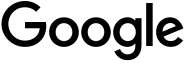

In [65]:
def get_price(id):
#     data_url = 'https://www.airbnb.com.ar/api/v2/pdp_listing_booking_details?_format=for_web_dateless&listing_id='+str(id)+'&_intents=p3_book_it&_interaction_type=pageload&_p3_impression_id=p3_1587692639_OF6XYXClqdkSagKG&_parent_request_uuid=07a17506-00b6-46ef-a23e-8ad6bd36bfc4&currency=USD&force_boost_unc_priority_message_type=&guests=1&key=d306zoyjsyarp7ifhu67rjxn52tv0t20&locale=es-AR&number_of_adults=1&number_of_children=0&number_of_infants=0&show_smart_promotion=0'
#     data_url = 'https://www.google.com'
    data_url = 'https://www.google.es'
    proxy = get_proxie()
    print(proxy)
    response = requests.get(
        data_url,
        proxies=proxy,
        headers=headersChrome
    )
    print(response)
    print(response.text)
    return response
#     data = json.loads(response.text)
#     if(data['pdp_listing_booking_details'][0]['p3_display_rate']['currency'] == 'USD'):
#         return int(data['pdp_listing_booking_details'][0]['p3_display_rate']['amount'])
#     else:
#         return None

res = get_price(5245)

In [71]:
res.headers

{'Date': 'Sat, 25 Apr 2020 01:22:29 GMT', 'Expires': '-1', 'Cache-Control': 'private, max-age=0', 'Content-Type': 'text/html; charset=UTF-8', 'Strict-Transport-Security': 'max-age=31536000', 'P3P': 'CP="This is not a P3P policy! See g.co/p3phelp for more info."', 'Content-Encoding': 'gzip', 'Server': 'gws', 'X-XSS-Protection': '0', 'X-Frame-Options': 'SAMEORIGIN', 'Set-Cookie': '1P_JAR=2020-04-25-01; expires=Mon, 25-May-2020 01:22:29 GMT; path=/; domain=.google.es; Secure, NID=203=KGJ8bLxkO2l1b0rNHABC4f6EQdRAwUQ2gXb3GJY7yDVgNwfN-MaZaCd5kYzZqezaM2e-q51dmmSyYmB-AsriIl5bziyyln0HBE3rAueg1erZRD46f0um0i_TZQ5J4Kx47vMkmwyX6z2TpxhYE3ANxL-6yAuMu_U4Trsoxa-nA1U; expires=Sun, 25-Oct-2020 01:22:29 GMT; path=/; domain=.google.es; Secure; HttpOnly', 'Alt-Svc': 'quic=":443"; ma=2592000; v="46,43",h3-Q050=":443"; ma=2592000,h3-Q049=":443"; ma=2592000,h3-Q048=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,h3-T050=":443"; ma=2592000', 'Transfer-Encoding': 'chunked'}

In [ ]:
def process_id(id):
    """process a single ID"""
    try: 
        return get_price(id)
    except:
        print('error in', id)
    return None

def process_range(id_range, store=None):
    total = len(id_range)
    """process a number of ids, storing the results in a dict"""
    if store is None:
        store = {}
    curr = 0
    for id in id_range:
        if(curr % 5 == 0):
            print(str(curr)+' of '+str(total))
        curr += 1
        store[id] = process_id(id)
    return store

from threading import Thread

def threaded_process_range(nthreads, id_range):
    """process the id range in a specified number of threads"""
    store = {}
    threads = []
    # create the threads
    for i in range(nthreads):
        ids = id_range[i::nthreads]
        t = Thread(target=process_range, args=(ids,store))
        threads.append(t)

    # start the threads
    [ t.start() for t in threads ]
    # wait for the threads to finish
    [ t.join() for t in threads ]
    return store

responses = threaded_process_range(
    10,
    targets.sample(frac=.33).values,
)

0 of 4313
0 of 4313
0 of 4313
0 of 4313
0 of 4313
0 of 4313
0 of 4313
0 of 4313
0 of 4312
0 of 4312
error in 10915406
error in 13700332
error in 12905157
error in 32527213
error in 36176586
5 of 4313
5 of 4313
5 of 4312
5 of 4313
5 of 4313
5 of 4313
5 of 4312
5 of 4313
5 of 4313
5 of 4313
error in 38402852
error in 32837714
error in 4781700
10 of 4313
10 of 4313
10 of 4312
10 of 4313
10 of 4312
10 of 431310 of 4313

10 of 4313
10 of 4313
10 of 4313
error in 39965050
error in 41937510
error in 42816195
error in 16485273
error in 25457583
15 of 4313
15 of 4313
15 of 4312
15 of 4313
15 of 4313
15 of 4313
15 of 4312
15 of 431315 of 4313

15 of 4313
error in 23567014
error in 37242684
20 of 4313
error in 29514193
20 of 4313
20 of 4313
error in 11555808
20 of 4313
20 of 4312
20 of 4313
20 of 4312
20 of 4313
20 of 4313
20 of 4313
error in 27572527
error in 41126603
error in 2878914
error in 26423914
25 of 4313
25 of 4313
25 of 4313
error in 41911265
25 of 4312
25 of 4312
25 of 4313
25 of 4313

error in 9607995
error in 20943288
error in 23109832
error in 40348770
error in 30984634
error in 6155072
error in 17415269
error in 16897050
error in 23172431
error in 39435705
error in 15296865
error in 6835487
error in 16821
error in 42457079
error in 23916344
error in 22449957
error in 36711786
error in 23482963
95 of 4313
error in 41945302
error in 38975612
95 of 4313
error in 40244514
error in 22179180
95 of 4313
error in 5406187
95 of 4312
error in 30586349
95 of 4313
error in 39104670
95 of 4313
error in 13064443
error in 21094505
error in 39026951
error in 34733186
error in 29054423
error in 42608006
error in 26670401
error in 31085155
error in 2586332
error in 15369209
95 of 4313
error in 24855025
error in 23803556
error in 41725360
95 of 4312
error in 42005206
error in 42707834
error in 25288989
error in 31174994
error in 16350431
95 of 4313
error in 502172
error in 17684359
error in 19345676
95 of 4313
error in 4727912
error in 41951268
error in 40350920
error in 26960163
e

error in 41505051
error in 36114258
error in 29778309
135 of 4313
error in 23960473
135 of 4313
error inerror inerror in 7762374 19679564
135 of 4313

 29928011
135 of 4312135 of 4313

error in 21937243
error in 39090241
error in 16368328
error in 13642073
error in 12492081
error in 36634650
error in 30348944
error inerror in 8571594
error in 36016455
 34641120
error in 39854821
error in 25070567
error in 9595863
135 of 4313
error in 32427238
error in 9243055
135 of 4312
error in 36806367
error inerror in 42645997
 42817294error in 39757435

error in 20018390
135 of 4313
error in 5443046
error in 41029058
error in 36848685
135 of 4313
error in 31392151
error in 42004565
error in 19391278
error in 41170555
error in 38071208
error in 13318522
error in 41012681
error in 5578778
error in 32577834
error in 24718885
error in 15166252
error in 9939746
error in 27507601
error in 38190040
error in 39725501
error in 41934239
error in 26199962
error in 39987747
140 of 4313
error in 35874763
error

error in 11782585
175 of 4312
error in 312107
error in 31193865
175 of 4313
error in 40610704
error in 14531646
error in 40727372
error in 40919170
error in 9943876
175 of 4313
error in 29364969
error in 24944899
error in 4329728
error in 409740
error in 17571670error in 21266726

175 of 4313
error in 9350645
175 of 4312
error in 29488640
error in 20211196
error in 7957634
error in 29731117
175 of 4313
error in 36631050
error in 20016493
error in 21382508
error in 23746579error in 14660137

error in 39610888
error in 41474950
error in 24015034
error in 17138302
error in 4405156
error in 22081513
180 of 4313
error in 23920387
error in 39523142
error in 14091664
error in 521806
error in 3563679
error in 33614825
error inerror in 6428913
 39581975
180 of 4313
error in 38977877
error in 32191161
error in 9061545
error in 30064645
180 of 4313
error in 33224938
error in 33096864error in 12567631

180 of 4313
error in 10659825
error in 15141938
error inerror in 21220444
 33110994
error in 185

error in 18093143
error in 42101442
error in 19102250
error in 35571444
error in 31020460
220 of 4313
error in 18632303
error in 35870200
error in 9880140
error in 40875171
error in 22588357
error in 22529131
error in 10548458
error in 4842232
error in 23370802
error in 41840000
error in 1195328
error in 33500525
error in 42446563
error in 38801997
error in 39938935
error in 8443325
error in 16961126
220 of 4313
error in 32141672
error in 27428046
error in 35879405error in 42781016
220 of 4313

error in 21664533
error in 16811720
error in 5148991
error in 11621322
220 of 4313
error in 38673098
220 of 4313
error in 19763459
error in 38295943
error in 42780087
220 of 4312
error in 42281029
error in 28520582
220 of 4313
error in 22209089
error in 17345954
error in 35337289
error in 560406
error in 11798782
error in 42457093
error in 37918616
220 of 4313
error in 1221332
error inerror in 3614159
error in 26052294
 34055680
error in 27694799
220 of 4312
error in 15252650
220 of 4313
error i

error in 40445094
260 of 4313
error in 9900224
error in 32865155
error in 32550253
error in 42206628
error inerror in 15257576
 252607
260 of 4313
error in 21281342
error in 20982257
260 of 4313
error in 17981267
error in 10789841
error in 2867115
260 of 4313
error in 3816665
error in 39490042
error in 9304254
260 of 4313
error in 6464881
error in 23131011
260 of 4312
error in 21180219
error inerror in 42140043
 6598270
error in 18191419
error in 18152287
error in 459066
error in 32588331
error in 41881734
error in 662245
error in 39242418
error in 37934898
error in 33085491
error in 7856476
error in 42686825
error in 33772698
260 of 4313
error in 41433265
error in 29294153
260 of 4313
error in 28628675
error in 38523749
error in 33374226
error in 7765579
260 of 4313
error inerror in 31309299
 13916994
260 of 4312
error in 24604281
error in 19887332
error in 3049232
error in 37427185
error in 13213983
error in 41721730
error in 31563889
error in 14055105
error in 34109471error in 33279

error inerror in 16164497
 4995083
error in 17975392
300 of 4313
error in 29938037
error in 11545503
error in 16347171
error in 30144241
error in 5669114
error in 9032763
error in 11870784
error inerror in 27169829
 255476
error in 9024737
error in 4606495
300 of 4312
error in 24019172
300 of 4312
error in 7727061
error in 41941892
error in 26299429
error in 9838585
error in 20984282
300 of 4313
error in 38794892
error in 40256769
error in 25865192
error in 22021344
error in 22163706
error in 19585942
error in 40900156
error in 20572447
error in 40161733
300 of 4313
error in 11412980
error in 42025749
300 of 4313
error in 31403415
error in 41277369
error in 31227259
error inerror in 41827333
305 of 4313
 20831478
error in 19767924
error in 18021716
error in 6291371
305 of 4313
error in 1370405
error in 16064539
error in 34565485
error in 28429583
305 of 4313
error in 33935998
error in 25969290
error in 36796521
error in 13940766
305 of 4313
error in 15253085
error inerror in 41215835
 

In [50]:
dfFinal.loc[list(responses.keys()), 'real_price'] = list(responses.values())

In [53]:
# dfFinal[['real_price', 'price']][pd.notna(dfFinal.real_price)]

In [55]:
dfFinal.to_pickle('../datasets/final_dataset.pkl')